In [18]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from unidecode import unidecode
from imblearn.under_sampling import NearMiss
import seaborn as sns
import re
import datetime
from sklearn import preprocessing
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/uf-dataset/UFCG.csv


# Loading UFCG dataset!

In [19]:
data= pd.read_csv("/kaggle/input/uf-dataset/UFCG.csv")
#Seting columns names
data.columns = ["Notification state", "Notification municipality",
                "Are you a health professional?", "Ethnicity", "Case evolution",
                "Test Type", "Residence Status", "Total Results", "Notification Date",
                "IgA Result", "CBO","Symptom- Throat Pain", "Symptom- Dyspnea","Symptom- Fever",
                "Symptom- Cough", "Symptom- Others","Symptom- Headache","Symptom- Taste Disorders",
                "Symptom- Olfactory Disorders", "Symptom- Coryza","Symptom- Asymptomatic", "CEP",
                "Safety Professional", "Result (PCR / Rapids)", "Race / Color", "Serological Test",
                "Gender", "Foreigner", "IgM Result", "Test Status", "Test Date (Serological)", "IgG Result",
                "Conditions- Decompensated chronic respiratory diseases", "Conditions- Chronic heart diseases",
                "Conditions- Diabetes","Conditions- Chronic kidney diseases in advanced stage (grades 3, 4 or 5)",
                "Conditions- Immunosuppression", "Conditions- Pregnant", "Conditions- Carrier of chromosomal diseases or state of immunological fragility",
                "Conditions- Postpartum (up to 45 days after delivery)", "Conditions- Obesity","neighborhood",
                "PCR / Rapid test date","description of symptoms", "closing date", "final classification",
                "municipality of residence","Symptom onset date","Mother's Full Name", "Cell Phone"]
print("Original dataset len:", len(data))

Original dataset len: 55676


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (3,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [20]:
data=data.fillna('n')
#Dropping repeated rows
data=data.drop_duplicates(subset=data.columns,keep='first')
data.head()

,Notification state,Notification municipality,Are you a health professional?,Ethnicity,Case evolution,Test Type,Residence Status,Total Results,Notification Date,IgA Result,...,Conditions- Obesity,neighborhood,PCR / Rapid test date,description of symptoms,closing date,final classification,municipality of residence,Symptom onset date,Mother's Full Name,Cell Phone
0,Pará,Canaã dos Carajás,Não,n,n,TESTE RÁPIDO - ANTICORPO,Paraíba,n,9/29/2020,n,...,Não,CENTRO,9/29/2020,n,n,Descartado,Campina Grande,9/29/2020,SEVERINA SANT ANA SILVA,(94) 9145-1464
1,Paraíba,Fagundes,Sim,n,n,TESTE RÁPIDO - ANTICORPO,Paraíba,n,9/29/2020,n,...,Não,CATOLE,9/29/2020,n,n,n,Campina Grande,9/29/2020,MARLEIDE CASTELO BRANCO E MEDEIROS,(83) 9
2,Paraíba,Massaranduba,Sim,n,n,TESTE RÁPIDO - ANTICORPO,Paraíba,n,9/29/2020,n,...,Não,CENTRO,9/29/2020,n,n,Descartado,Campina Grande,9/29/2020,n,(83) 98157-8870
3,Paraíba,Massaranduba,Sim,n,n,TESTE RÁPIDO - ANTICORPO,Paraíba,n,9/29/2020,n,...,Não,CONCEICAO,8/29/2020,n,n,Descartado,Campina Grande,9/29/2020,n,(83) 9889-7507
4,Paraíba,Cabaceiras,Sim,n,n,TESTE RÁPIDO - ANTICORPO,Paraíba,n,9/29/2020,n,...,Não,PRATA,9/29/2020,n,n,Descartado,Campina Grande,9/29/2020,n,(83) 98760-7279


# Filtering rows marked only as completed('Concluído') test,final classification as confirmed or discarded, no asymptomatic patient and only patients with test result defined as positive or negative!

In [21]:

dt=data[(data["Test Status"]=='Concluído') & (data["final classification"]!='n') 
        & (data["final classification"]!='Síndrome Gripal Não Especificada ')&
        (data["Symptom- Asymptomatic"]=='Não')]

dt=dt[(dt["Result (PCR / Rapids)"]!='n') & (dt["Result (PCR / Rapids)"]!='Inconclusivo ou Indeterminado')]



# Selecting columns and parting dataset!


we will only use pcr and antibody tests!

In [22]:

test_pcr=dt[(dt["Test Type"]=='RT-PCR')] 
test_antibody=dt[(dt["Test Type"]=='TESTE RÁPIDO - ANTICORPO')|
                  (dt["Test Type"]=='TESTE RÁPIDO - ANTÍGENO')]

columns=["Symptom- Throat Pain", "Symptom- Dyspnea","Symptom- Fever",
        "Symptom- Cough","Symptom- Headache","Symptom- Taste Disorders",
        "Symptom- Olfactory Disorders", "Symptom- Coryza","description of symptoms",
         "Gender","Are you a health professional?", "PCR / Rapid test date",
         "Symptom onset date","Result (PCR / Rapids)"]
test_pcr=test_pcr[columns]
test_antibody=test_antibody[columns]


# Resolving inconsistency on the symptom columns,since, most symptoms columns are marked as no(não), but in the symptom description column, the same patient has the symptoms!

example: the column Symptom- Headache is marked as no(Não), but,the column description of symptoms,
shows that the patient has a headache(DOR DE CABEÇA)

In [23]:

test_pcr.loc[55644]

Symptom- Throat Pain                                                   Não
Symptom- Dyspnea                                                       Não
Symptom- Fever                                                         Não
Symptom- Cough                                                         Não
Symptom- Headache                                                      Não
Symptom- Taste Disorders                                               Não
Symptom- Olfactory Disorders                                           Não
Symptom- Coryza                                                        Não
description of symptoms           DOR DE CABEÇA, TONTURA, FRAQUEZA, CORIZA
Gender                                                            Feminino
Are you a health professional?                                         Não
PCR / Rapid test date                                             6/2/2020
Symptom onset date                                                6/2/2020
Result (PCR / Rapids)    

Before applying the algorithm to update the symptom columns, we performed an analysis of the most frequent symptoms described in the symptom description column!

In [24]:
def update_symptoms_columns(result):
    Lsymt=data["description of symptoms"]
    k=0
    l=0
    for symt in Lsymt:
        #removing accentuation
        symt=unidecode(symt)
        symt=symt.upper()
        #removing special symbols
        symt=re.split( r'[),;.+/(]',symt)
            
        for s in symt:
                s=s.split()
                
                if('SAUDE' in s):
                    result.iloc[k:k+1,9:10]='Sim'
                
                if(('CEFALEIA' in s) | ('CABECA' in s)| ('CEFALEIAA' in s)| ('CEFAALEIA' in s)):
                    result.iloc[k:k+1,4:5]='Sim'

                if('Febre' in s):
                    result.iloc[:,2:3]='Sim'

                if(('TOSE' in s) | ('TOSSE' in s)| ('TOSSINDO' in s)):
                    result.iloc[k:k+1,3:4]='Sim'
                

                if('CORIZA' in s)| ('CORIZE' in s)| ('CORISA' in s): 
                    result.iloc[k:k+1,7:8]='Sim'
                    
                if(('OLFATO' in s)|('ANOSMIA' in s)|('ANSMIA' in s)|('CHEIRO' in s)):
                    result.iloc[k:k+1,6:7]='Sim'

                if(('PALADAR' in s)|('AGEUSIA' in s)|('AUGESIA' in s)|
                   ('APETITE' in s)|('SABOR' in s)|('INAPETENCIA' in s)):
                    result.iloc[k:k+1,5:6]='Sim'

                if(('RESPIRATORIO' in s)|('RESPIRACAO' in s)|
                     ('RESPIRAR' in s) |('AR' in s)| ('RESPIRATORIA'in s)|
                     ('ASMATICA'in s)|('RESP' in s)|('DISPNEIA' in s)):
                    result.iloc[k:k+1,1:2]='Sim'      
               
        k+=1
        
    return result


test_pcr=update_symptoms_columns(test_pcr)
test_antibody=update_symptoms_columns(test_antibody)

#Deleting column "description of symptoms"
del test_pcr["description of symptoms"]
del test_antibody["description of symptoms"]



# Drop rows with all the symptoms marked as no(Não)!

In [25]:
def drop_rows_without_no_sym(dt_covid):
    dt_drop=dt_covid[(dt_covid["Symptom- Throat Pain"]=="Não") & (dt_covid["Symptom- Dyspnea"]=="Não")
        & (dt_covid["Symptom- Fever"]=="Não") & (dt_covid["Symptom- Cough"]=="Não") 
        & (dt_covid["Symptom- Headache"]=="Não") & (dt_covid["Symptom- Taste Disorders"]=="Não")
        & (dt_covid["Symptom- Olfactory Disorders"]=="Não") & (dt_covid["Symptom- Coryza"]=="Não")]
    dt_covid=dt_covid.drop(dt_drop.index)
    return dt_covid

test_pcr=drop_rows_without_no_sym(test_pcr)
test_antibody=drop_rows_without_no_sym(test_antibody) 




# Pre-processing dates!

In [26]:
def split_dates(date):
    lista_date=[]
   
    for k in date:
    
        lista_date.append(k.split('/'))
    return lista_date

def create_colunm_days_after_onset(lista_date_teste,lista_date_sin,dt_covid):
    dt_covid['days after onset']=None
    lista_days=[]
    
    for l in range(len(lista_date_teste)):
        #convert dates to days
        d0 = datetime.date(int(lista_date_teste[l][2]),int(lista_date_teste[l][0]),int(lista_date_teste[l][1]))
        d1 = datetime.date(int(lista_date_sin[l][2]),int(lista_date_sin[l][0]),int(lista_date_sin[l][1]))
        delta = d0 - d1
        lista_days.append(delta.days)
    #set days after onset values
    dt_covid['days after onset']=lista_days
    Standardisation = preprocessing.StandardScaler()
    #Drop dates columns
    del dt_covid["Symptom onset date"]
    del dt_covid["PCR / Rapid test date"]
    return dt_covid

# Pre-processing Gender!
we eliminated rows with Gender marked as undefined(Indefinido)!

In [27]:
def pre_processing_gender(dt_covid):
    dt_covid=dt_covid[dt_covid['Gender']!='Indefinido']
    return dt_covid
test_pcr=pre_processing_gender(test_pcr)
test_antibody=pre_processing_gender(test_antibody.copy())

In [28]:
def call_function(data):
    data=data[(data["PCR / Rapid test date"]!='n') & (data["Symptom onset date"]!='n')].copy()
    lista_date_sin=split_dates(data["Symptom onset date"])
    lista_date_teste=split_dates(data["PCR / Rapid test date"])
    data=create_colunm_days_after_onset(lista_date_teste,lista_date_sin,data)
    
    return data

test_antibody=call_function(test_antibody)
#get just antibody test with days after onset between, 10-97 days
test_antibody=test_antibody[(test_antibody['days after onset']>=10) & 
                            (test_antibody['days after onset']<=97)]
del test_antibody['days after onset']

test_pcr=call_function(test_pcr)
#get just pcr test with days after onset between, 0-97 days
test_pcr=test_pcr[(test_pcr['days after onset']>=0) & (test_pcr['days after onset']<=97)]
del test_pcr['days after onset']




# Resolving inconsistency "Result (PCR / Rapids)"column,since,there are patients with equals fields values and class("Result (PCR / Rapids)" marked as positive and negative!

This inconsistency occurs because there are patients with only demographic information that differentiate them,but, we are not using !

In [29]:
def part_dataset(dt_covid,sub):
    
    #part dataset with only class("Result (PCR / Rapids)") marked as negative
    neg=dt_covid[dt_covid["Result (PCR / Rapids)"]=='Negativo']
    
    #part dataset with only class("Result (PCR / Rapids)") marked as positive
    pos=dt_covid[dt_covid["Result (PCR / Rapids)"]=='Positivo']
    del neg["Result (PCR / Rapids)"]
    del pos["Result (PCR / Rapids)"]
    
    #part dataset with only unique values fom dataset pos
    pos_uniq=pos.drop_duplicates(subset=sub)
    
    neg_array=neg.iloc[:,:].values
    pos_uniq_array=pos_uniq.iloc[:,:].values
    pos_dupli_array=pos.iloc[:,:].values
    
    return neg,pos,neg_array, pos_uniq_array,pos_dupli_array

sub1=["Symptom- Throat Pain", "Symptom- Dyspnea","Symptom- Fever",
        "Symptom- Cough","Symptom- Headache","Symptom- Taste Disorders","Symptom- Olfactory Disorders",
        "Symptom- Coryza","Gender","Are you a health professional?"]


neg_pcr,pos_pcr,neg_array_pcr,pos_uniq_array_pcr,pos_dupli_array_pcr=part_dataset(test_pcr,sub1)
neg_ant,pos_ant,neg_array_ant,pos_uniq_array_ant,pos_dupli_array_ant=part_dataset(test_antibody,sub1)  



In [30]:
def resolve_class_conflict(d_ori,pos_uniq_array,l_comp):
    lpp=dict()
    dict_count=dict()
    #run all the unique values from positive dataset
    for k in range(len(pos_uniq_array)):
        p=0
        lista_index=[]
        #run all the values to compare if is equal to the unique values from positive dataset
        for i in range(len(l_comp)):

            comparison=pos_uniq_array[k:k+1,:]==l_comp[i:i+1,:]
             #if the values are equal
            if(comparison.all()):
                #count how many equal values exist!
                p+=1
                #add l_comp value index in lista_index!
                lista_index.append(d_ori.iloc[i:i+1,:].index[0])
        #hold the number of same values
        dict_count[k]=p
        #hold all the lists of index
        lpp[k]=lista_index
    return dict_count,lpp
#pcr
dict_count_pcr,lpp_pcr=resolve_class_conflict(pos_pcr,pos_uniq_array_pcr,pos_dupli_array_pcr)
dict_count_neg_pcr,lpn_pcr=resolve_class_conflict(neg_pcr,pos_uniq_array_pcr, neg_array_pcr)
#antibody
dict_count_ant,lpp_ant=resolve_class_conflict(pos_ant,pos_uniq_array_ant,pos_dupli_array_ant)
dict_count_neg_ant,lpn_ant=resolve_class_conflict(neg_ant,pos_uniq_array_ant, neg_array_ant)


In [31]:
def get_conflict_values_keys(dict_count_neg,dict_count):
    dnp=pd.DataFrame(index=dict_count_neg.keys())
    dnp['neg']=dict_count_neg.values()
    dnp['pos']=dict_count.values()
    dnp=dnp[(dnp['neg']>0) & (dnp['pos']>0)]
    #get just the keys which the total rows number of neg values is less than pos values
    neg_smaller=dnp[dnp['neg'] < dnp['pos']]
    #get just the keys which the total rows number of pos values is less than neg values
    pos_smaller=dnp[dnp['neg'] > dnp['pos']]
    #get just the keys which the total rows number of pos values is equal to neg values
    pos_neg_equal=dnp[dnp['neg'] == dnp['pos']]
    return neg_smaller, pos_smaller, pos_neg_equal
#pcr
neg_smaller_pcr,pos_smaller_pcr, pos_neg_equal_pcr=get_conflict_values_keys(dict_count_neg_pcr,dict_count_pcr)

#antibody
neg_smaller_ant,pos_smaller_ant, pos_neg_equal_ant=get_conflict_values_keys(dict_count_neg_ant,dict_count_ant)



In [32]:
def get_index(data,l_data,l_index):
    
    for x in data.index:
        for k in l_data[x]:
            l_index.append(k)
    
       
    return l_index
#pcr
l_index_pcr=[]
l_index_pcr=get_index(neg_smaller_pcr,lpn_pcr,l_index_pcr)
l_index_pcr=get_index(pos_smaller_pcr,lpp_pcr,l_index_pcr)
l_index_pcr=get_index(pos_neg_equal_pcr,lpn_pcr,l_index_pcr)
l_index_pcr=get_index(pos_neg_equal_pcr,lpp_pcr,l_index_pcr)
#antibody
l_index_ant=[]
l_index_ant=get_index(neg_smaller_ant,lpn_ant,l_index_ant)
l_index_ant=get_index(pos_smaller_ant,lpp_ant,l_index_ant)
l_index_ant=get_index(pos_neg_equal_ant,lpn_ant,l_index_ant)
l_index_ant=get_index(pos_neg_equal_ant,lpp_ant,l_index_ant)


Drop inconsistency values!

In [33]:
test_pcr=test_pcr.drop(l_index_pcr)
test_antibody=test_antibody.drop(l_index_ant)


Scaling feature days after onset!

In [34]:
def scale_days(data):
    Standardisation = preprocessing.StandardScaler() 
  
    # Scaled feature 
    data['days after onset']= Standardisation.fit_transform(data.iloc[:, 11:12].values)
    return data
#test_pcr=scale_days(test_pcr)
#test_antibody=scale_days(test_antibody)

In [35]:
def convert_to_binary(dt_covid):
    dt_covid=dt_covid.replace(to_replace =["Sim"],value =0) 
    dt_covid=dt_covid.replace(to_replace =["Não"],value =1)
    dt_covid=dt_covid.replace(to_replace =["Positivo"],value=0) 
    dt_covid=dt_covid.replace(to_replace =["Negativo"],value=1)
    dt_covid=dt_covid.replace(to_replace =["Feminino"],value=0)
    dt_covid=dt_covid.replace(to_replace =["Masculino"],value=1)
    #drop none values
    dt_covid=dt_covid.replace(to_replace =["n"],value =None)
    dt_covid=dt_covid.dropna()
    return dt_covid
test_pcr=convert_to_binary(test_pcr)
test_antibody=convert_to_binary(test_antibody)
test_pcr['Gender']=test_pcr['Gender'].astype(int)
test_antibody['Gender']=test_antibody['Gender'].astype(int)


# Matching the classes!

In [36]:
def match_classes(dt_covid):
    y=dt_covid["Result (PCR / Rapids)"]

    x=dt_covid.iloc[:,:10]
    x['index']=dt_covid.index
    nr = NearMiss()
    x,y=nr.fit_sample(x,y)
    return x,y
x_pcr,y_pcr=match_classes(test_pcr)
x_ant,y_ant=match_classes(test_antibody)
x_ant['Class']=y_ant
data_antibody=x_ant.copy()
x_pcr['Class']=y_pcr
data_pcr=x_pcr.copy()


In [37]:
pcr_state=data.loc[data_pcr['index'].values]
pcr_state['Notification state'].value_counts()

Paraíba                1718
Rio Grande do Norte      10
São Paulo                 4
Pernambuco                3
Bahia                     2
Ceará                     1
Amazonas                  1
Mato Grosso do Sul        1
Name: Notification state, dtype: int64

In [38]:
antibody_state=data.loc[data_antibody['index'].values]
antibody_state['Notification state'].value_counts()

Paraíba                922
Paraná                   3
Pernambuco               2
Rio Grande do Norte      2
Pará                     2
Ceará                    1
Roraima                  1
Mato Grosso do Sul       1
Name: Notification state, dtype: int64

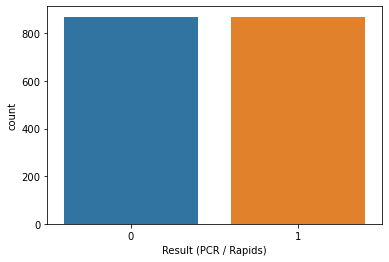

In [39]:
def vizualize_class(x,y):
    sns.countplot(x=y)
#pcr
vizualize_class(x_pcr,y_pcr)

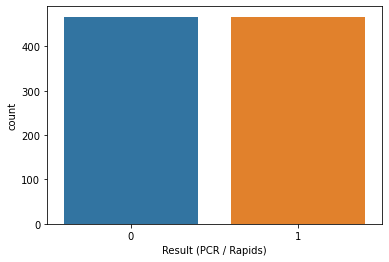

In [40]:
#antibody
vizualize_class(x_ant,y_ant)

Createing both dataset !

In [41]:
both_data=pd.concat([data_pcr,data_antibody]).reset_index()
del both_data['index']
del data_pcr['index']
del data_antibody['index']

#both_data_gender=pd.concat([data_fe,data_ma]).reset_index()
#del both_data_gender['index']

Dataset informations!

In [42]:
#2674

In [43]:
both_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2674 entries, 0 to 2673
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   level_0                         2674 non-null   int64 
 1   Symptom- Throat Pain            2674 non-null   int64 
 2   Symptom- Dyspnea                2674 non-null   int64 
 3   Symptom- Fever                  2674 non-null   int64 
 4   Symptom- Cough                  2674 non-null   int64 
 5   Symptom- Headache               2674 non-null   int64 
 6   Symptom- Taste Disorders        2674 non-null   int64 
 7   Symptom- Olfactory Disorders    2674 non-null   int64 
 8   Symptom- Coryza                 2674 non-null   int64 
 9   Gender                          2674 non-null   int64 
 10  Are you a health professional?  2674 non-null   object
 11  Class                           2674 non-null   int64 
dtypes: int64(11), object(1)
memory usage: 250.8+ KB


In [44]:
#934

In [45]:
data_antibody.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 934 entries, 0 to 933
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Symptom- Throat Pain            934 non-null    int64 
 1   Symptom- Dyspnea                934 non-null    int64 
 2   Symptom- Fever                  934 non-null    int64 
 3   Symptom- Cough                  934 non-null    int64 
 4   Symptom- Headache               934 non-null    int64 
 5   Symptom- Taste Disorders        934 non-null    int64 
 6   Symptom- Olfactory Disorders    934 non-null    int64 
 7   Symptom- Coryza                 934 non-null    int64 
 8   Gender                          934 non-null    int64 
 9   Are you a health professional?  934 non-null    object
 10  index                           934 non-null    int64 
 11  Class                           934 non-null    int64 
dtypes: int64(11), object(1)
memory usage: 87.7+ KB


In [46]:
#1740

In [47]:
data_pcr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1740 entries, 0 to 1739
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   Symptom- Throat Pain            1740 non-null   int64
 1   Symptom- Dyspnea                1740 non-null   int64
 2   Symptom- Fever                  1740 non-null   int64
 3   Symptom- Cough                  1740 non-null   int64
 4   Symptom- Headache               1740 non-null   int64
 5   Symptom- Taste Disorders        1740 non-null   int64
 6   Symptom- Olfactory Disorders    1740 non-null   int64
 7   Symptom- Coryza                 1740 non-null   int64
 8   Gender                          1740 non-null   int64
 9   Are you a health professional?  1740 non-null   int64
 10  index                           1740 non-null   int64
 11  Class                           1740 non-null   int64
dtypes: int64(12)
memory usage: 163.2 KB


In [48]:
#export dataset
data_antibody.to_csv('data_antibody.csv',index=False)
data_pcr.to_csv('pcr_data.csv',index=False)
both_data.to_csv('both_covid_data.csv',index=False)

